In [1]:
#Import etc
import cv2
import glob
import os
import numpy as np
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import sklearn
import tensorflow
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Dropout
from keras.layers import Conv2D, MaxPooling2D
from keras.preprocessing.image import *

files=glob.glob("Videos/*/*/")
#Print to check it seems ok
print(files)
print([i+"*.*" for i in  files])
filetree=[glob.glob(i+"*.*") for i in  files]
print(np.shape(filetree))
print(np.shape(filetree[0]))
print(np.shape(filetree[1]))


Populating the interactive namespace from numpy and matplotlib
['Videos/without/20180224_193809/', 'Videos/without/20180224_192617/', 'Videos/with/20180224_192237/', 'Videos/with/20180224_193623/']
['Videos/without/20180224_193809/*.*', 'Videos/without/20180224_192617/*.*', 'Videos/with/20180224_192237/*.*', 'Videos/with/20180224_193623/*.*']
(4,)
(1908,)
(4721,)


Using TensorFlow backend.


Videos/without/20180224_193809/frame00883.jpg


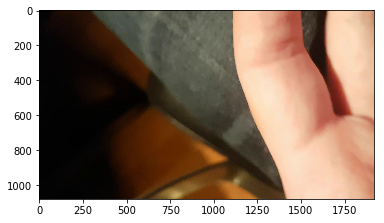

Videos/without/20180224_192617/frame02084.jpg


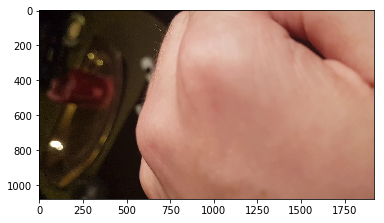

Videos/with/20180224_192237/frame03730.jpg


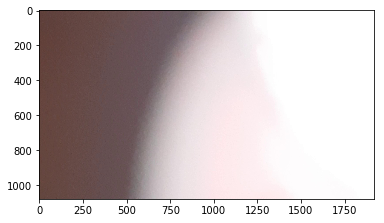

Videos/with/20180224_193623/frame02209.jpg


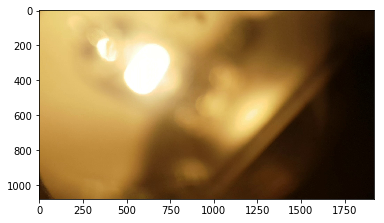

In [2]:
#show image examples
for images in filetree:
    image=np.random.choice(images)
    print(image)
    img=mpimg.imread(image)
    imgplot = plt.imshow(img)
    plt.show()

In [3]:
# Sort the images from the 2 classes
hud=filetree[2]+filetree[3]
nohud=filetree[0]+filetree[1]
data=[(x,True) for x in hud] + [(x,False) for x in nohud]
data=sorted(data, key=lambda name: name[0])
#for d in data:
#    print(d)


In [4]:
# Split into training and validation set, due to the fact we use a video as input, we don't want
# to just split randomly as it's too likily the validation and training will bee too similar,  

train=[]
validation=[]
r=data#list(range(16000))
start=0
while(start<len(r)):
    reminder=len(r)-start
    #print(reminder)
    length=reminder if reminder < 10 else np.random.randint(1,reminder if reminder < 400 else 400)
    #print(length)
    if len(train) == 0:
        train=train + r[start:start+length]
    elif len(test)/len(train)>2.5:
        train=train + r[start:start+length]
    else:
        validation=validation + r[start:start+length]
    start=start+length
np.random.shuffle(train)
np.random.shuffle(validation)
#print(train)
#print(test)

TypeError: object of type 'method' has no len()

In [ ]:
def generator(samples, train=True,batch_size=64):
    num_samples = len(samples)
    while 1:  # Loop forever so the generator never terminates
        samples = sklearn.utils.shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset + batch_size]

            images = []
            ishud = []
            for batch_sample in batch_samples:
                image_path = batch_sample[0]
                image = cv2.imread(image_path)
                image =  cv2.resize(image, (128, 128)) 
                #if train: #Add augument later
                #    image = augument_image(image)
                images.append(image)
                ishud.append(batch_sample[1])
            X_train = np.array(images)
            y_train = np.array(ishud)
            yield sklearn.utils.shuffle(X_train, y_train)


In [ ]:


train_generator = generator(train,train=True)
validation_generator = generator(validation,train=False)


''' Model starts here'''
model = Sequential()
model.add(Lambda(lambda x: x / 127.5 - 1. , input_shape=(128,128,3)))
model.add(Conv2D(24, (5, 5), activation="relu", strides=(2, 2)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.5, noise_shape=None, seed=None))
model.add(Conv2D(36, (5, 5), activation="relu"))
model.add(Conv2D(48, (3, 3), activation="relu", strides=(2, 2)))
model.add(Conv2D(64, (3, 3), activation="relu"))
model.add(Conv2D(64, (3, 3), activation="relu"))
model.add(Flatten())
model.add(Dense(100))
model.add(Dropout(0.5, noise_shape=None, seed=None))
model.add(Dense(50))
model.add(Dropout(0.5, noise_shape=None, seed=None))
model.add(Dense(10))
model.add(Dropout(0.5, noise_shape=None, seed=None))
model.add(Dense(1))


In [ ]:
model.compile(loss='mse', optimizer='adam')
model.fit_generator(train_generator, steps_per_epoch = len(train)//64, validation_data=validation_generator,
                    validation_steps=len(validation)//64, nb_epoch=1)
model.save('model.h5')
#first one is to just make sure it seems to work.. have had problems that sometimes the network predicts
#the same output no mather of input

#model.fit_generator(train_generator, steps_per_epoch = len(train_samples)//64, validation_data=validation_generator,
#                   validation_steps=len(validation_samples)//64, nb_epoch=5)##
#model.save('modelout.h5')
